In [1]:
# Linear algebra and numerical operations
import numpy as np
import pandas as pd
import autograd.numpy as np
from autograd import grad
from functools import partial

# Visualization
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.preprocessing import PolynomialFeatures

# Random number generation
from random import random, seed

# Warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
def TestFunction(x, y, noise=False):
    if noise: 
        random_noise = np.random.normal(0, 0.1 , x.shape)
    else: 
        random_noise = 0
    return  x**2 + y**2 + 2*x*y + random_noise

def FrankeFunction(x, y, noise=False):
    if noise: 
        random_noise = np.random.normal(0, 0.1 , x.shape)
    else: 
        random_noise = 0
    
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4 + random_noise

def MSE(y_model, y_data):
    n = np.size(y_model)
    y_data = y_data.reshape(-1, 1)
    y_model = y_model.reshape(-1, 1)
    return np.sum((y_data - y_model)**2)/n

def create_X(x, y, n):
	if len(x.shape) > 1:
		x = np.ravel(x)
		y = np.ravel(y)
    
	N = len(x)
	l = int((n+1)*(n+2)/2)
	X = np.ones((N,l))
    
	for i in range(1, n+1):
		q = int((i)*(i+1)/2)
		for k in range(i+1):
			X[:,q+k] = (x**(i-k))*(y**k)
	return X

def generate_data(noise=True, step_size=0.05, FrankesFunction=True):
    # Arrange x and y
    x = np.arange(0, 1, step_size)
    y = np.arange(0, 1, step_size)
    # Create meshgrid of x and y
    X, Y = np.meshgrid(x, y)
    
    if FrankesFunction:
        # Calculate the values for Franke function
        z = FrankeFunction(X, Y, noise=noise).flatten()
    else:
        z = TestFunction(X, Y, noise=noise).flatten()

    # Flatten x and y for plotting
    x = X.flatten()
    y = Y.flatten()
    return x, y, z

def mse_and_r2_sk(y_real, y_pred):
    mse = mean_squared_error(y_real, y_pred)
    r2 = r2_score(y_real, y_pred)
    return mse, r2

# Analytic gradient

In [3]:
class GradientDescend:
    def __init__(self, optimizer="gd", learning_rate=0.001, max_epochs=100, batch_size=20,
                learning_rate_decay=0.9, patience=20, delta_momentum=0.3, lmb=0.001,
                tol=1e-8, delta=1e-8, rho=0.9, beta1=0.9, beta2=0.99, momentum=True,
                learning_rate_decay_flag=False, Ridge=False, method=None, change=0.0):
        # Parameter configuration
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs
        self.batch_size = int(batch_size)
        self.learning_rate_decay = learning_rate_decay
        self.patience = patience
        self.delta_momentum = delta_momentum if momentum else 0
        self.lmb = lmb if Ridge else 0
        self.tol = tol
        self.delta = delta
        self.rho = rho
        self.beta1 = beta1
        self.beta2 = beta2
        self.learning_rate_decay_flag = learning_rate_decay_flag
        self.method = method
        
        # State variables for optimization
        self.theta = 0.0
        self.first_moment = 0.0
        self.second_moment = 0.0
        self.iter = 0
        self.change = change
        self.gradient_squared = 0.0  # Cumulative gradient for Adagrad and RMSprop

    def compute_hessian_eig_max(self, X):
        """Calculate the maximum eigenvalue of the Hessian, useful for defining an optimal learning rate."""
        H = (2.0 / len(X)) * np.matmul(X.T, X)
        if self.lmb:
            H += 2 * self.lmb * np.eye(X.shape[1])
        return 1.0 / np.max(np.linalg.eigvals(H))
    
    def cost_function(self, X, y, beta):
        """Compute the cost function, adding an L2 norm penalty if Ridge regularization is applied."""
        residuals = np.dot(X, beta) - y
        cost = np.sum(residuals ** 2) / len(X) + self.lmb * (np.sqrt(np.sum(beta ** 2)))**2
        return cost
    
    def _learning_schedule(self, t):
        """Generate a variable learning rate for learning rate decay."""
        return self.learning_rate / (1 + self.learning_rate_decay * t)
    
    def gd_step(self, X, y, thetas):
        """Gradient descent step with optional momentum."""
        gradient = grad(self.cost_function, 2)(X, y, thetas)
        change = self.learning_rate * gradient + self.delta_momentum * self.change
        thetas -= change
        self.change = change
        return thetas

    def RMSprop_step(self, X, y, thetas):
        """RMSprop step, which updates the gradient with a moving average to stabilize updates."""
        gradients = grad(self.cost_function, 2)(X, y, thetas)
        self.gradient_squared = self.rho * self.gradient_squared + (1 - self.rho) * gradients ** 2
        thetas -= self.learning_rate * gradients / (self.delta + np.sqrt(self.gradient_squared))
        return thetas
    
    def ADAM_step(self, X, y, thetas):
        """ADAM optimization step using momentum for first and second moments."""
        gradients = grad(self.cost_function, 2)(X, y, thetas)
        self.first_moment = self.beta1 * self.first_moment + (1 - self.beta1) * gradients
        self.second_moment = self.beta2 * self.second_moment + (1 - self.beta2) * gradients ** 2
        first_unbiased = self.first_moment / (1 - self.beta1 ** self.iter)
        second_unbiased = self.second_moment / (1 - self.beta2 ** self.iter)
        thetas -= self.learning_rate * first_unbiased / (np.sqrt(second_unbiased) + self.delta)
        return thetas
    
    def Adagrad_GD_step(self, X, y, thetas):
        """Adagrad step, adjusting the learning rate based on cumulative gradients."""
        gradients = grad(self.cost_function, 2)(X, y, thetas)
        self.gradient_squared += gradients ** 2
        thetas -= self.learning_rate * gradients / (self.delta + np.sqrt(self.gradient_squared))
        return thetas
    
    # Optimization methods
    def gradient_descent(self, X_train, y_train, X_val, y_val):
        """Implementation of standard Gradient Descent with optional momentum and learning rate decay."""
        
        thetas = np.random.randn(X_train.shape[1], 1)
        patience_counter = 0
        best_val_error = float('inf')
        best_thetas = np.copy(thetas)
        
        for epoch in range(self.max_epochs):
            thetas = self.gd_step(X_train, y_train, thetas)
            if self.learning_rate_decay_flag:
                val_loss = mean_squared_error(y_val, np.dot(X_val, thetas))
                if val_loss < best_val_error - self.tol:
                    best_val_error = val_loss
                    best_thetas = thetas
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter > self.patience:
                        self.learning_rate *= self.learning_rate_decay
                        patience_counter = 0
        return best_thetas

    def stochastic_gradient_descent(self, X_train, y_train, X_val, y_val):
        """Implementation of Stochastic Gradient Descent with optional momentum and batch processing."""
        
        num_samples = len(X_train)
        thetas = np.random.randn(X_train.shape[1],1)
        patience_counter = 0
        best_val_error = float('inf')
        best_thetas = np.copy(thetas)
        
        # Select optimization method based on user input
        if self.method == 'sgd':
            method_ = self.gd_step
        elif self.method == 'RMSprop':
            method_ = self.RMSprop_step
        elif self.method == 'ADAM':
            self.m = np.zeros((X_train.shape[1], 1))
            self.v = np.zeros((X_train.shape[1], 1))
            self.t = 0
            method_ = self.ADAM_step
        elif self.method == 'Adagrad_GD':
            method_ = self.Adagrad_GD_step
        else:
            raise ValueError(f"Unknown optimization method: {self.method}")
        
        # Loop over epochs and batch the dataset
        for epoch in range(self.max_epochs):
            index = np.random.permutation(num_samples)
            self.iter += 1
            for i in range(0, num_samples, self.batch_size):
                random_index = index[i:i + self.batch_size]
                batch_X = X_train[random_index]
                batch_y = y_train[random_index]
                thetas = method_(batch_X, batch_y, thetas)
        
        # Update learning rate if decay is enabled
        if self.learning_rate_decay_flag:
            val_loss = mean_squared_error(y_val, np.dot(X_val, thetas))
            if val_loss < best_val_error - self.tol:
                best_val_error = val_loss
                best_thetas = thetas
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter > self.patience and self.learning_rate_decay_flag:
                    self.learning_rate *= self.learning_rate_decay
        return best_thetas
    
    def fit(self, X_train, y_train, X_val, y_val):
        """Main training method."""
        y_train = y_train.reshape(-1, 1)
        y_val = y_val.reshape(-1, 1)
        
        if not self.learning_rate_decay_flag:
            self.learning_rate = self.compute_hessian_eig_max(X_train)
        
        if self.optimizer == "gd":
            self.thetas = self.gradient_descent(X_train, y_train, X_val, y_val)
            return self.thetas
        elif self.optimizer == "sgd":
            self.thetas = self.stochastic_gradient_descent(X_train, y_train, X_val, y_val)
            return  self.thetas
        else:
            raise ValueError("Unsupported optimizer. Use 'gd' or 'sgd'.")
        
    def predict(self, X):
        return np.dot(X, self.thetas).reshape(-1, 1)

## OLS

In [4]:
np.random.seed(2024)
x, y, z = generate_data()
degree = 5
X = create_X(x, y, degree)
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=42)

### Gradient Descend

In [5]:
# Plain Gradient Descent with fix learning rate
gamma = 0.01

model = GradientDescend(momentum = False, learning_rate = gamma)
model.fit(X_train, z_train, X_test, z_test)
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
train_error = MSE(train_pred, z_train)
test_error = MSE(test_pred, z_test)    

print(f'The train error is: {train_error:.5f}')
print(f'The test error is: {test_error:.5f}')

The train error is: 2.19463
The test error is: 1.93647


Best gamma: 0.03071 
Test error: 0.42620


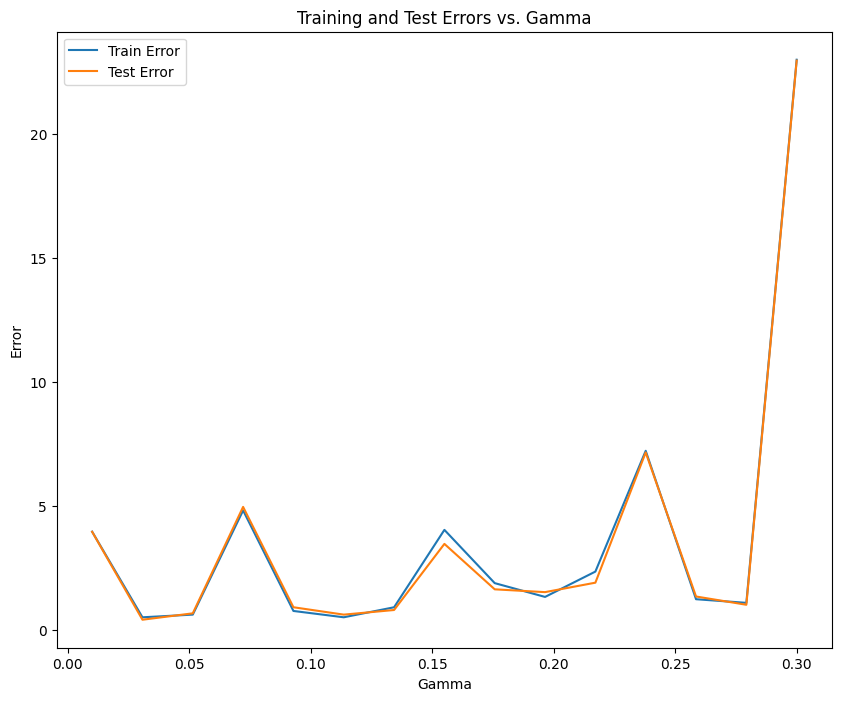

In [6]:
np.random.seed(2024)
gamma = np.linspace(0.01, 0.3, 15)

train_errors = np.zeros(len(gamma))
test_errors = np.zeros(len(gamma))
for g in range(len(gamma)):
    model = GradientDescend(momentum = False, learning_rate = gamma[g], max_epochs=1000)
    model.fit(X_train, z_train, X_test, z_test)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    train_errors[g] = MSE(train_pred, z_train)
    test_errors[g] = MSE(test_pred, z_test)

optimal_index = np.argmin(test_errors)
optimal_gamma = gamma[optimal_index]
optimal_test_error = test_errors[optimal_index]

print(f"Best gamma: {optimal_gamma:.5f} \nTest error: {optimal_test_error:.5f}")

# ---------------------- Plot the results ----------------------
plt.figure(figsize=(10, 8))
plt.plot(gamma, train_errors, label="Train Error")
plt.plot(gamma, test_errors, label="Test Error")
plt.title("Training and Test Errors vs. Gamma")
plt.xlabel("Gamma")
plt.ylabel("Error")
plt.legend()
plt.show()

### Gradient Descend with momentum

Optimal learning rate (gamma): 0.30000
Optimal momentum factor (delta): 0.97143
Minimum test error: 0.08493


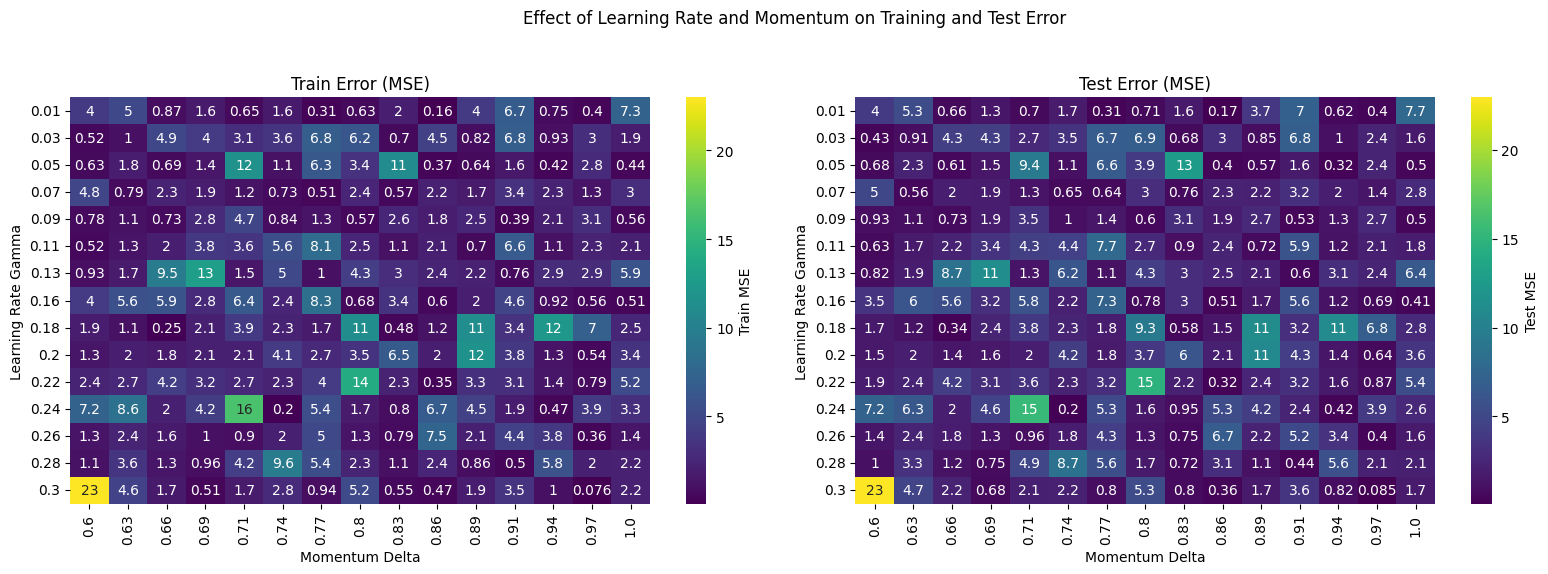

In [7]:
# Momentum
np.random.seed(2024)
gamma = np.linspace(0.01, 0.3, 15)
delta = np.linspace(0.6, 1, 15)

train_errors_mom = np.zeros((len(gamma), len(delta)))
test_errors_mom = np.zeros((len(gamma), len(delta)))
for d in range(len(delta)):
    for g in range(len(gamma)):
        model = GradientDescend(learning_rate=gamma[g], delta_momentum=delta[d])
        model.fit(X_train, z_train, X_test, z_test)
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        
        train_errors_mom[g, d] = MSE(train_pred, z_train)
        test_errors_mom[g, d] = MSE(test_pred, z_test)

min_test_error_idx = np.unravel_index(np.argmin(test_errors_mom), test_errors_mom.shape)
optimal_gamma = gamma[min_test_error_idx[0]]
optimal_delta = delta[min_test_error_idx[1]]

print(f"Optimal learning rate (gamma): {optimal_gamma:.5f}")
print(f"Optimal momentum factor (delta): {optimal_delta:.5f}")
print(f"Minimum test error: {test_errors_mom[min_test_error_idx]:.5f}")

# ---------------------- Plot the results ----------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap for Train Error
sns.heatmap(train_errors_mom, xticklabels=np.round(delta, 2), yticklabels=np.round(gamma, 2),
            cmap="viridis", ax=ax1, annot=True, cbar_kws={'label': 'Train MSE'})
ax1.set_title("Train Error (MSE)")
ax1.set_xlabel("Momentum Delta")
ax1.set_ylabel("Learning Rate Gamma")

# Heatmap for Test Error
sns.heatmap(test_errors_mom, xticklabels=np.round(delta, 2), yticklabels=np.round(gamma, 2),
            cmap="viridis", ax=ax2, annot=True, cbar_kws={'label': 'Test MSE'})
ax2.set_title("Test Error (MSE)")
ax2.set_xlabel("Momentum Delta")
ax2.set_ylabel("Learning Rate Gamma")

plt.suptitle("Effect of Learning Rate and Momentum on Training and Test Error")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

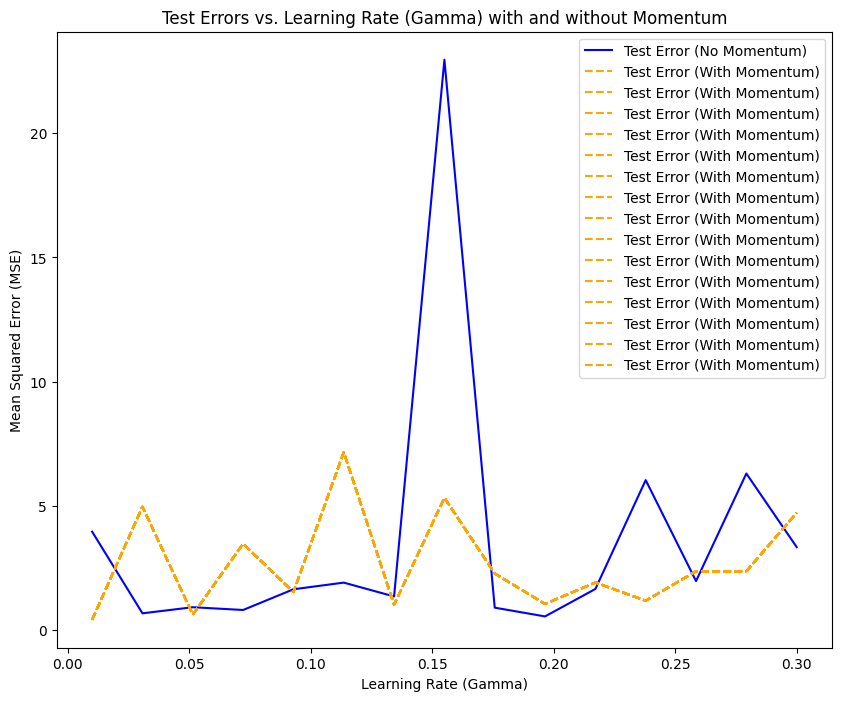

In [8]:
# Plain Gradient Descent with momentum and fix learning rate
np.random.seed(2024)
gamma = np.linspace(0.01, 0.3, 15)

train_errors = np.zeros(len(gamma))
test_errors = np.zeros(len(gamma))
train_errors_mom = np.zeros((len(gamma), len(delta)))
test_errors_mom = np.zeros((len(gamma), len(delta)))
for g in range(len(gamma)):
    model = GradientDescend(momentum = False, learning_rate = gamma[g])
    model.fit(X_train, z_train, X_test, z_test)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_errors[g] = MSE(train_pred, z_train)
    test_errors[g] = MSE(test_pred, z_test)
    
    # Momentum
    model_m = GradientDescend(learning_rate=gamma[g], delta_momentum=optimal_delta)
    model_m.fit(X_train, z_train, X_test, z_test)
    train_pred = model_m.predict(X_train)
    test_pred = model_m.predict(X_test)
    train_errors_mom[g] = MSE(train_pred, z_train)
    test_errors_mom[g] = MSE(test_pred, z_test)

# ---------------------- Plot the results ----------------------
plt.figure(figsize=(10, 8))
plt.plot(gamma, test_errors, label="Test Error (No Momentum)", linestyle='-', color='blue')
plt.plot(gamma, test_errors_mom, label="Test Error (With Momentum)", linestyle='--', color='orange')
plt.title("Test Errors vs. Learning Rate (Gamma) with and without Momentum")
plt.xlabel("Learning Rate (Gamma)")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.show()

### Stocastic Gradient Descend

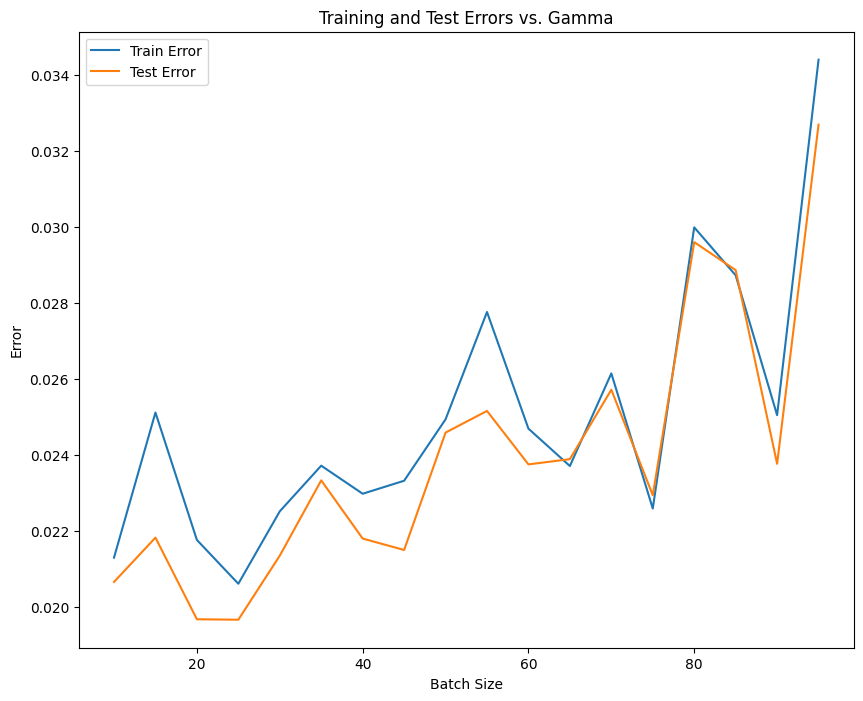

In [9]:
# Mini-batch

np.random.seed(2024)

gamma = 0.01
delta = optimal_delta
eta = 0.9
batch_size = np.arange(10, 100, 5)

train_errors = np.zeros(len(batch_size))
test_errors = np.zeros(len(batch_size))

for b in range(len(batch_size)):
    model = GradientDescend(optimizer="sgd", method="sgd", learning_rate=gamma, delta_momentum=delta, learning_rate_decay_flag=True, learning_rate_decay=eta, batch_size=batch_size[b])
    model.fit(X_train, z_train, X_test, z_test)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_errors[b] = MSE(train_pred, z_train)
    test_errors[b] = MSE(test_pred, z_test)

# ---------------------- Plot the results ----------------------
plt.figure(figsize=(10, 8))
plt.plot(batch_size, train_errors, label="Train Error")
plt.plot(batch_size, test_errors, label="Test Error")
plt.title("Training and Test Errors vs. Gamma")
plt.xlabel("Batch Size")
plt.ylabel("Error")
plt.legend()
plt.show()

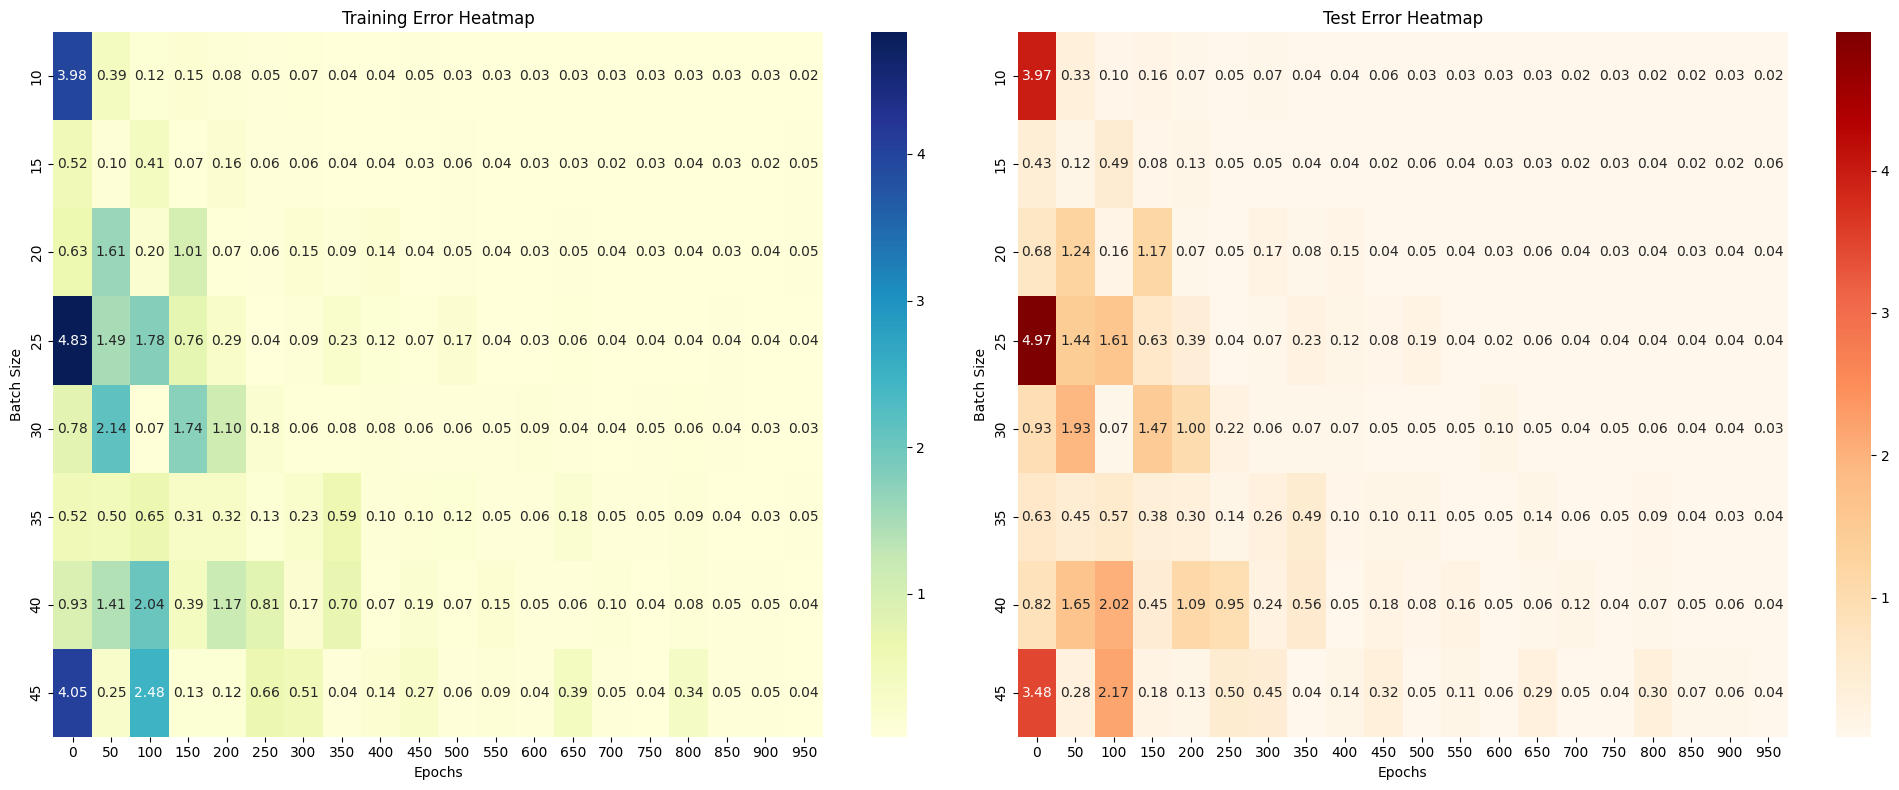

In [10]:
# Mini-batch and epoch

np.random.seed(2024)

gamma = 0.01
delta = optimal_delta
eta = 0.9
batch_size = np.arange(10, 50, 5)
max_epochs = np.arange(0, 1000, 50)

train_errors = np.zeros((len(batch_size), len(max_epochs)))
test_errors = np.zeros((len(batch_size), len(max_epochs)))

for epoch in range(len(max_epochs)):
    for b in range(len(batch_size)):
        model = GradientDescend(optimizer="sgd", method="sgd", learning_rate=gamma, delta_momentum=delta, learning_rate_decay_flag=True, learning_rate_decay=eta, batch_size=batch_size[b], max_epochs=epoch)
        model.fit(X_train, z_train, X_test, z_test)
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        train_errors[b, epoch] = MSE(train_pred, z_train)
        test_errors[b, epoch] = MSE(test_pred, z_test)

# ---------------------- Plot the results ----------------------
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Training Error Heatmap
sns.heatmap(train_errors, ax=ax[0], annot=True, fmt=".2f", cmap="YlGnBu", 
            xticklabels=max_epochs, yticklabels=batch_size)
ax[0].set_title("Training Error Heatmap")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Batch Size")

# Test Error Heatmap
sns.heatmap(test_errors, ax=ax[1], annot=True, fmt=".2f", cmap="OrRd", 
            xticklabels=max_epochs, yticklabels=batch_size)
ax[1].set_title("Test Error Heatmap")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Batch Size")

plt.tight_layout()
plt.show()

Text(0, 0.5, 'train MSE')

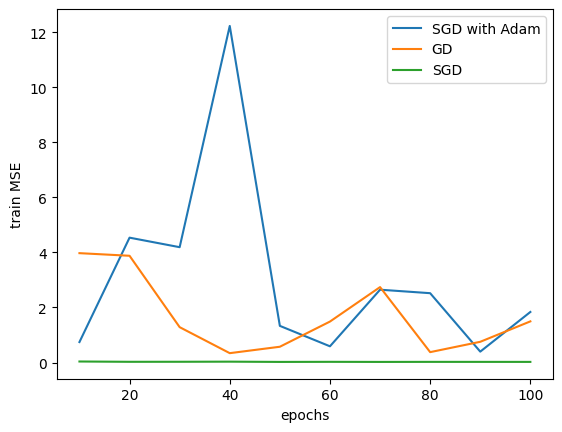

In [11]:
# Convergence and stability

np.random.seed(2024)

gamma = optimal_gamma
delta = 0.6
eta = 0.9
batch_size = 25
epochs = np.arange(10, 101, 10)

gd = np.zeros(len(epochs))
sgd = np.zeros(len(epochs))
sgd_adam = np.zeros(len(epochs))

for i in range(len(epochs)):
    model = GradientDescend(optimizer="gd", method="gd", learning_rate=gamma, delta_momentum=delta, max_epochs=epochs[i])
    scores = model.fit(X_train, z_train, X_test, z_test)
    pred_train = model.predict(X_train)
    gd[i] = MSE(pred_train, z_train)

    model = GradientDescend(optimizer="sgd", method="sgd", learning_rate=gamma, delta_momentum=delta,
                            learning_rate_decay_flag=True, learning_rate_decay=eta, batch_size=batch_size, max_epochs=epochs[i])
    scores = model.fit(X_train, z_train, X_test, z_test)
    pred_train = model.predict(X_train)
    sgd[i] = MSE(pred_train, z_train)

    model = GradientDescend(optimizer="sgd", method="ADAM", batch_size=batch_size)
    scores = model.fit(X_train, z_train, X_test, z_test)
    pred_train = model.predict(X_train)
    sgd_adam[i] = MSE(pred_train, z_train)
    
# ---------------------- Plot the results ----------------------
# OLS = np.zeros(len(epochs))+ MSE_val[0,0]
plt.plot(epochs, sgd_adam, label="SGD with Adam")
plt.plot(epochs, gd, label="GD")
plt.plot(epochs, sgd, label="SGD")
# plt.plot(epochs, OLS, label="OLS")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("train MSE")

### Adagrad, RMSprop and Adam

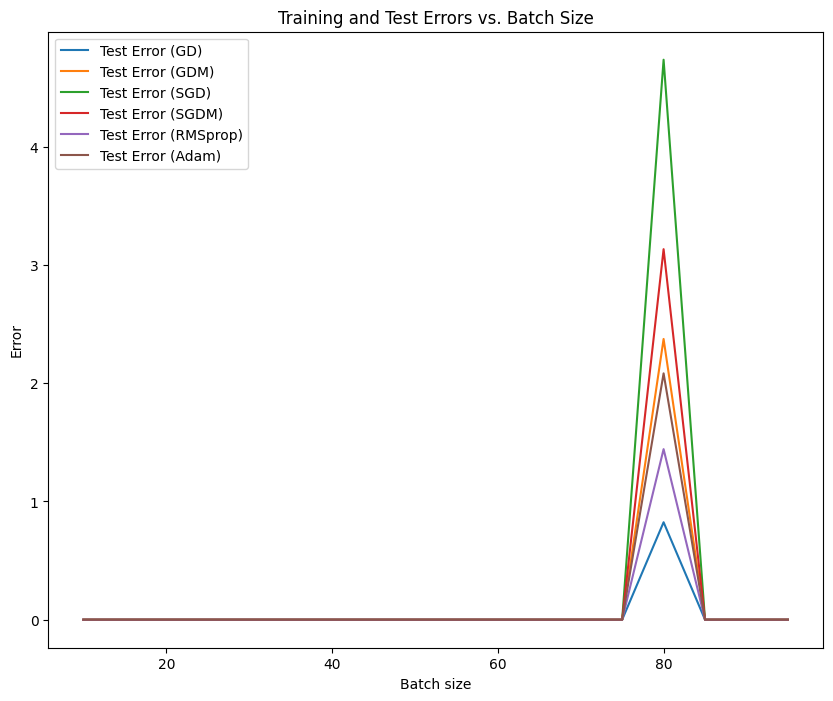

In [12]:
# Variable Batch_size
np.random.seed(2024)

gamma = 0.01
delta = optimal_delta
eta = 0.9
batch_size = np.arange(10, 100, 5)

test_errors_gd = np.zeros(len(batch_size))
test_errors_gdm = np.zeros(len(batch_size))
test_errors_sgd = np.zeros(len(batch_size))
test_errors_sgdm = np.zeros(len(batch_size))
test_errors_rms = np.zeros(len(batch_size))
test_errors_adam = np.zeros(len(batch_size))

for b in range(len(batch_size)):
    # ---------------------- GD without momentum ----------------------
    model = GradientDescend(momentum=False, method="Adagrad_GD", batch_size=batch_size[b])
    model.fit(X_train, z_train, X_test, z_test)
    test_pred = model.predict(X_test)
    test_errors_gd[g] = MSE(test_pred, z_test)
    
    # ---------------------- GD with momentum ----------------------
    model = GradientDescend(method="Adagrad_GD", batch_size=batch_size[b])
    model.fit(X_train, z_train, X_test, z_test)
    test_pred = model.predict(X_test)
    test_errors_gdm[g] = MSE(test_pred, z_test)
    
    # ---------------------- SGD without momentum ----------------------
    model = GradientDescend(momentum=False, optimizer='sgd', method="Adagrad_GD", batch_size=batch_size[b])
    model.fit(X_train, z_train, X_test, z_test)
    test_pred = model.predict(X_test)
    test_errors_sgd[g] = MSE(test_pred, z_test)
    
    # ---------------------- SGD with momentum ----------------------
    model = GradientDescend(optimizer='sgd', method="Adagrad_GD", batch_size=batch_size[b])
    model.fit(X_train, z_train, X_test, z_test)
    test_pred = model.predict(X_test)
    test_errors_sgdm[g] = MSE(test_pred, z_test)
    
    # ---------------------- RMS with momentum ----------------------
    model = GradientDescend(optimizer='sgd', method="RMSprop", batch_size=batch_size[b])
    model.fit(X_train, z_train, X_test, z_test)
    test_pred = model.predict(X_test)
    test_errors_rms[g] = MSE(test_pred, z_test)
    
    # ---------------------- ADAM with momentum ----------------------
    model = GradientDescend(optimizer='sgd', method="ADAM", batch_size=batch_size[b])
    model.fit(X_train, z_train, X_test, z_test)
    test_pred = model.predict(X_test)
    test_errors_adam[g] = MSE(test_pred, z_test)

# ---------------------- Plot the results ----------------------
plt.figure(figsize=(10, 8))
plt.plot(batch_size, test_errors_gd, label="Test Error (GD)")
plt.plot(batch_size, test_errors_gdm, label="Test Error (GDM)")
plt.plot(batch_size, test_errors_sgd, label="Test Error (SGD)")
plt.plot(batch_size, test_errors_sgdm, label="Test Error (SGDM)")
plt.plot(batch_size, test_errors_rms, label="Test Error (RMSprop)")
plt.plot(batch_size, test_errors_adam, label="Test Error (Adam)")

plt.title("Training and Test Errors vs. Batch Size")
plt.xlabel("Batch size")
plt.ylabel("Error")
plt.legend()
plt.show()

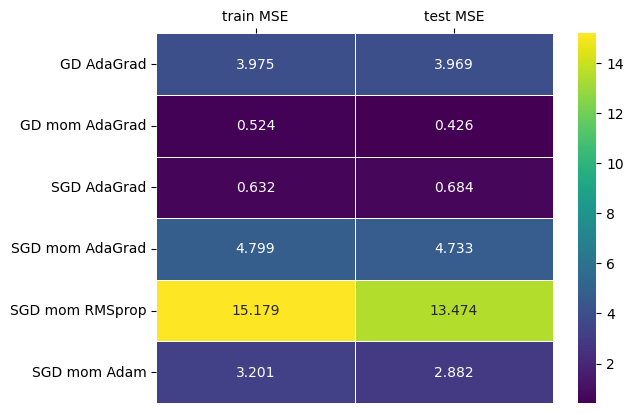

In [13]:
np.random.seed(2024)

gamma = 0.01
delta = optimal_delta
eta = 0.9
batch_size = 25

MSE_val = np.zeros((6, 2))

# ---------------------- GD without momentum ----------------------
model = GradientDescend(momentum=False, method="Adagrad_GD", batch_size=batch_size)
model.fit(X_train, z_train, X_test, z_test)
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
MSE_val[0, 0] = MSE(train_pred, z_train)
MSE_val[0, 1] = MSE(test_pred, z_test)

# ---------------------- GD with momentum ----------------------
model = GradientDescend(method="Adagrad_GD", batch_size=batch_size)
model.fit(X_train, z_train, X_test, z_test)
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
MSE_val[1, 0] = MSE(train_pred, z_train)
MSE_val[1, 1] = MSE(test_pred, z_test)

# ---------------------- SGD without momentum ----------------------
model = GradientDescend(momentum=False, optimizer='sgd', method="Adagrad_GD", batch_size=batch_size)
model.fit(X_train, z_train, X_test, z_test)
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
MSE_val[2, 0] = MSE(train_pred, z_train)
MSE_val[2, 1] = MSE(test_pred, z_test)

# ---------------------- SGD with momentum ----------------------
model = GradientDescend(optimizer='sgd', method="Adagrad_GD", batch_size=batch_size)
model.fit(X_train, z_train, X_test, z_test)
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
MSE_val[3, 0] = MSE(train_pred, z_train)
MSE_val[3, 1] = MSE(test_pred, z_test)

# ---------------------- RMS with momentum ----------------------
model = GradientDescend(optimizer='sgd', method="RMSprop", batch_size=batch_size)
model.fit(X_train, z_train, X_test, z_test)
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
MSE_val[4, 0] = MSE(train_pred, z_train)
MSE_val[4, 1] = MSE(test_pred, z_test)

# ---------------------- ADAM with momentum ----------------------
model = GradientDescend(optimizer='sgd', method="ADAM", batch_size=batch_size)
model.fit(X_train, z_train, X_test, z_test)
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
MSE_val[5, 0] = MSE(train_pred, z_train)
MSE_val[5, 1] = MSE(test_pred, z_test)

# ---------------------- Plot the results ----------------------
index = ["GD AdaGrad", "GD mom AdaGrad", "SGD AdaGrad", "SGD mom AdaGrad", "SGD mom RMSprop", "SGD mom Adam"]
MSE_val = np.around(MSE_val, decimals=3)
df = pd.DataFrame(MSE_val, index=index, columns=["train MSE", "test MSE"])
fig = sns.heatmap(df, cmap="viridis", annot=True, linewidth=.5, fmt=".3f")
fig.set(xlabel="", ylabel="")
fig.xaxis.tick_top()

## Ridge

In [14]:
np.random.seed(2024)
x, y, z = generate_data()
degree = 5
X = create_X(x, y, degree)
X_train, X_test, z_train, z_test = train_test_split(X, z, test_size=0.2, random_state=42)

### Gradient Descend

In [15]:
# Plain Gradient Descent with fix learning rate
gamma = 0.01

model = GradientDescend(momentum = False, learning_rate = gamma, Ridge=True)
model.fit(X_train, z_train, X_test, z_test)
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
train_error = MSE(train_pred, z_train)
test_error = MSE(test_pred, z_test)    

print(f'The train error is: {train_error:.5f}')
print(f'The test error is: {test_error:.5f}')

The train error is: 2.19463
The test error is: 1.93647


Best gamma: 0.03071 
Test error: 0.42620


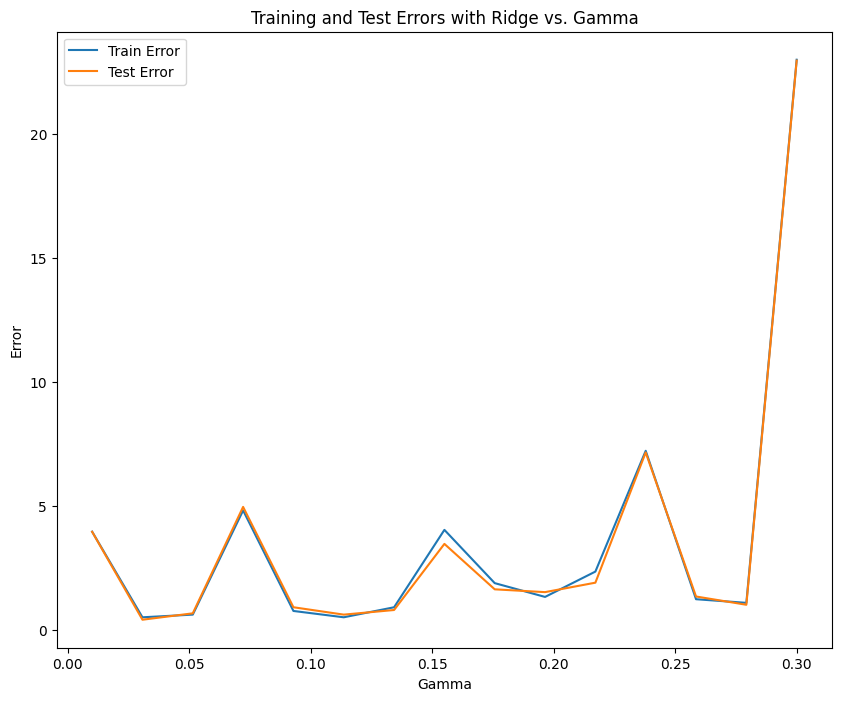

In [16]:
np.random.seed(2024)
gamma = np.linspace(0.01, 0.3, 15)

train_errors = np.zeros(len(gamma))
test_errors = np.zeros(len(gamma))
for g in range(len(gamma)):
    model = GradientDescend(momentum = False, learning_rate = gamma[g], max_epochs=1000, Ridge=True)
    model.fit(X_train, z_train, X_test, z_test)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    train_errors[g] = MSE(train_pred, z_train)
    test_errors[g] = MSE(test_pred, z_test)

optimal_index = np.argmin(test_errors)
optimal_gamma = gamma[optimal_index]
optimal_test_error = test_errors[optimal_index]

print(f"Best gamma: {optimal_gamma:.5f} \nTest error: {optimal_test_error:.5f}")

# ---------------------- Plot the results ----------------------
plt.figure(figsize=(10, 8))
plt.plot(gamma, train_errors, label="Train Error")
plt.plot(gamma, test_errors, label="Test Error")
plt.title("Training and Test Errors with Ridge vs. Gamma")
plt.xlabel("Gamma")
plt.ylabel("Error")
plt.legend()
plt.show()

### Gradient Descend with momentum

Optimal learning rate (gamma): 0.30000
Optimal momentum factor (delta): 0.97143
Minimum test error: 0.08493


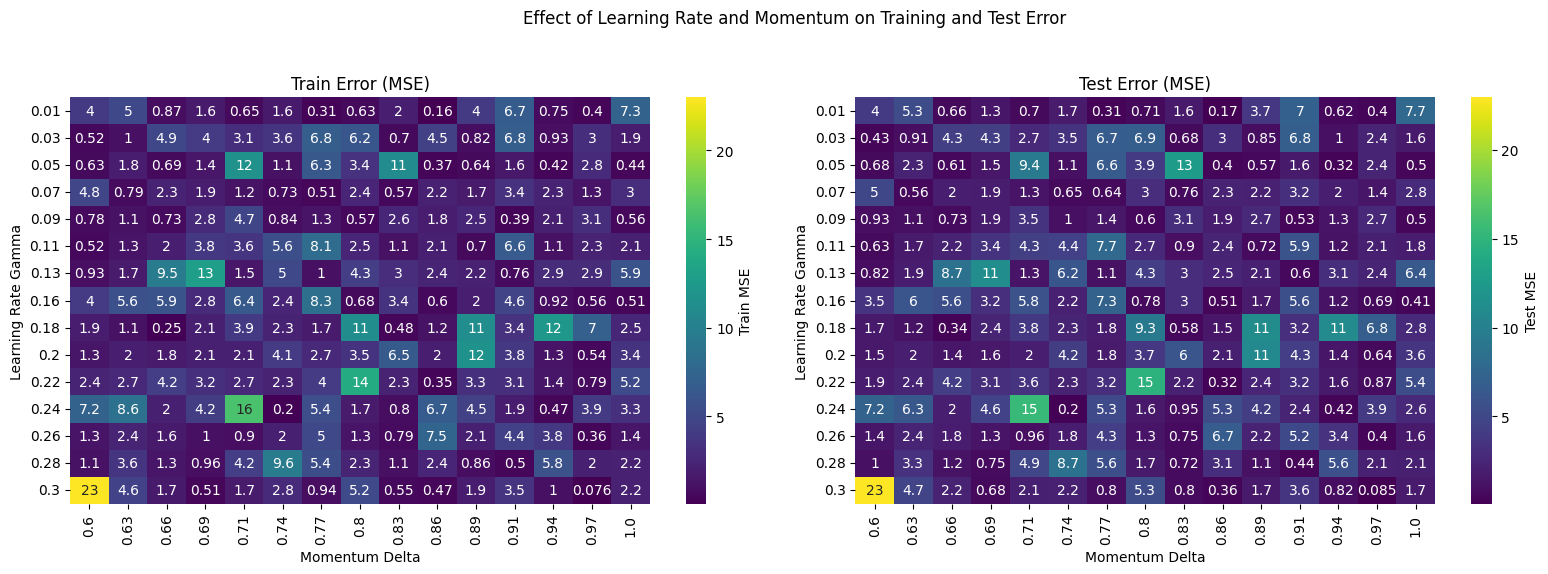

In [17]:
# Momentum
np.random.seed(2024)
gamma = np.linspace(0.01, 0.3, 15)
delta = np.linspace(0.6, 1, 15)

train_errors_mom = np.zeros((len(gamma), len(delta)))
test_errors_mom = np.zeros((len(gamma), len(delta)))
for d in range(len(delta)):
    for g in range(len(gamma)):
        model = GradientDescend(learning_rate=gamma[g], delta_momentum=delta[d], Ridge=True)
        model.fit(X_train, z_train, X_test, z_test)
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        
        train_errors_mom[g, d] = MSE(train_pred, z_train)
        test_errors_mom[g, d] = MSE(test_pred, z_test)

min_test_error_idx = np.unravel_index(np.argmin(test_errors_mom), test_errors_mom.shape)
optimal_gamma = gamma[min_test_error_idx[0]]
optimal_delta = delta[min_test_error_idx[1]]

print(f"Optimal learning rate (gamma): {optimal_gamma:.5f}")
print(f"Optimal momentum factor (delta): {optimal_delta:.5f}")
print(f"Minimum test error: {test_errors_mom[min_test_error_idx]:.5f}")

# ---------------------- Plot the results ----------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap for Train Error
sns.heatmap(train_errors_mom, xticklabels=np.round(delta, 2), yticklabels=np.round(gamma, 2),
            cmap="viridis", ax=ax1, annot=True, cbar_kws={'label': 'Train MSE'})
ax1.set_title("Train Error (MSE)")
ax1.set_xlabel("Momentum Delta")
ax1.set_ylabel("Learning Rate Gamma")

# Heatmap for Test Error
sns.heatmap(test_errors_mom, xticklabels=np.round(delta, 2), yticklabels=np.round(gamma, 2),
            cmap="viridis", ax=ax2, annot=True, cbar_kws={'label': 'Test MSE'})
ax2.set_title("Test Error (MSE)")
ax2.set_xlabel("Momentum Delta")
ax2.set_ylabel("Learning Rate Gamma")

plt.suptitle("Effect of Learning Rate and Momentum on Training and Test Error")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

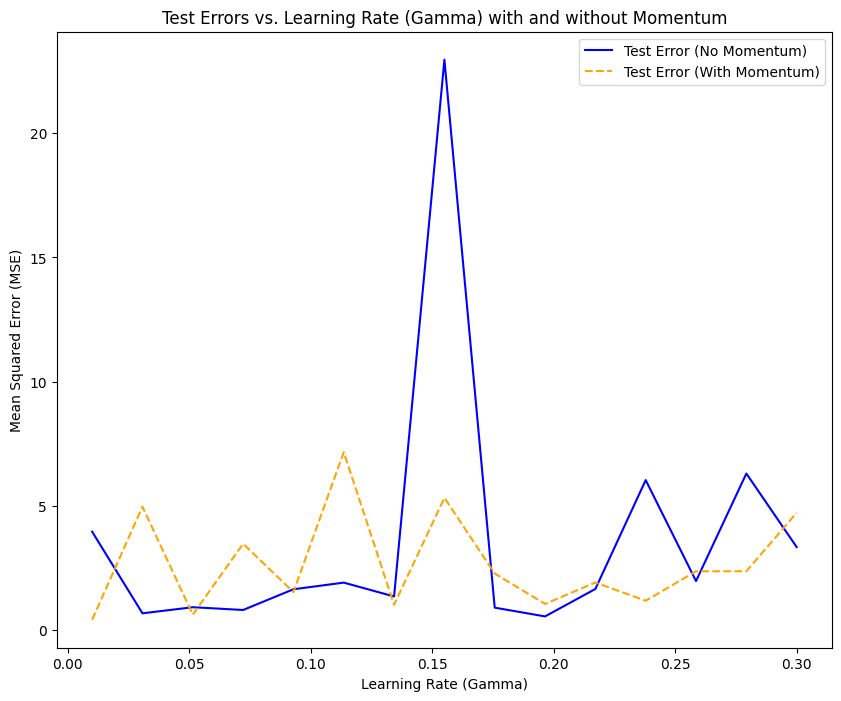

In [18]:
# Plain Gradient Descent with momentum and fix learning rate
np.random.seed(2024)
gamma = np.linspace(0.01, 0.3, 15)

train_errors = np.zeros(len(gamma))
test_errors = np.zeros(len(gamma))
train_errors_mom = np.zeros(len(gamma))
test_errors_mom = np.zeros(len(gamma))
for g in range(len(gamma)):
    model = GradientDescend(momentum = False, learning_rate = gamma[g], Ridge=True)
    model.fit(X_train, z_train, X_test, z_test)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_errors[g] = MSE(train_pred, z_train)
    test_errors[g] = MSE(test_pred, z_test)
    
    # Momentum
    model_m = GradientDescend(learning_rate=gamma[g], delta_momentum=optimal_delta, Ridge=True)
    model_m.fit(X_train, z_train, X_test, z_test)
    train_pred = model_m.predict(X_train)
    test_pred = model_m.predict(X_test)
    train_errors_mom[g] = MSE(train_pred, z_train)
    test_errors_mom[g] = MSE(test_pred, z_test)

# ---------------------- Plot the results ----------------------
plt.figure(figsize=(10, 8))
plt.plot(gamma, test_errors, label="Test Error (No Momentum)", linestyle='-', color='blue')
plt.plot(gamma, test_errors_mom, label="Test Error (With Momentum)", linestyle='--', color='orange')
plt.title("Test Errors vs. Learning Rate (Gamma) with and without Momentum")
plt.xlabel("Learning Rate (Gamma)")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.show()

### Stocastic Gradient Descend

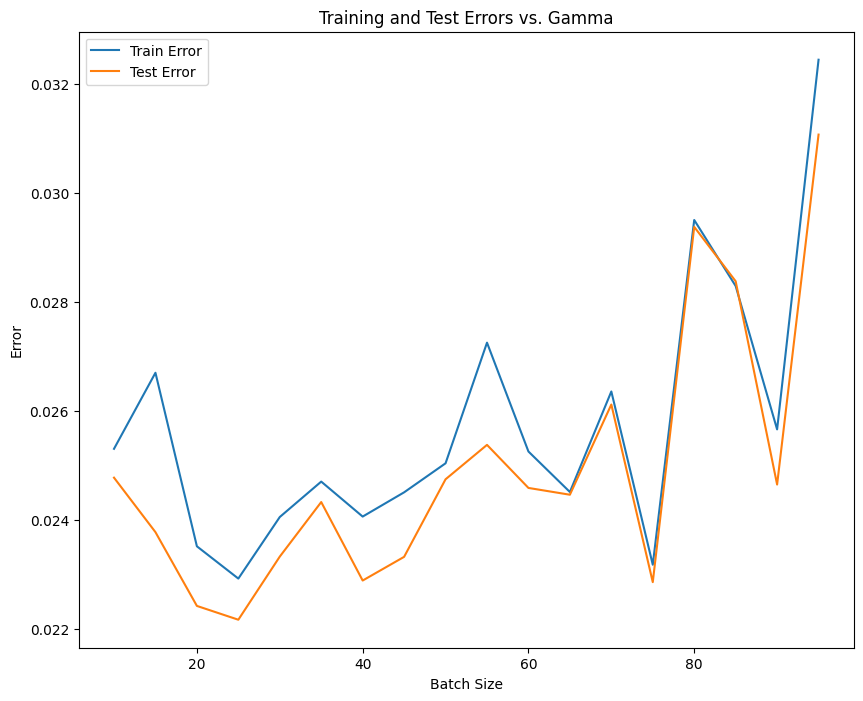

In [19]:
# Mini-batch

np.random.seed(2024)

gamma = 0.01
delta = optimal_delta
eta = 0.9
batch_size = np.arange(10, 100, 5)

train_errors = np.zeros(len(batch_size))
test_errors = np.zeros(len(batch_size))

for b in range(len(batch_size)):
    model = GradientDescend(optimizer="sgd", method="sgd", Ridge=True, learning_rate=gamma, delta_momentum=delta, learning_rate_decay_flag=True, learning_rate_decay=eta, batch_size=batch_size[b])
    model.fit(X_train, z_train, X_test, z_test)
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_errors[b] = MSE(train_pred, z_train)
    test_errors[b] = MSE(test_pred, z_test)

# ---------------------- Plot the results ----------------------
plt.figure(figsize=(10, 8))
plt.plot(batch_size, train_errors, label="Train Error")
plt.plot(batch_size, test_errors, label="Test Error")
plt.title("Training and Test Errors vs. Gamma")
plt.xlabel("Batch Size")
plt.ylabel("Error")
plt.legend()
plt.show()

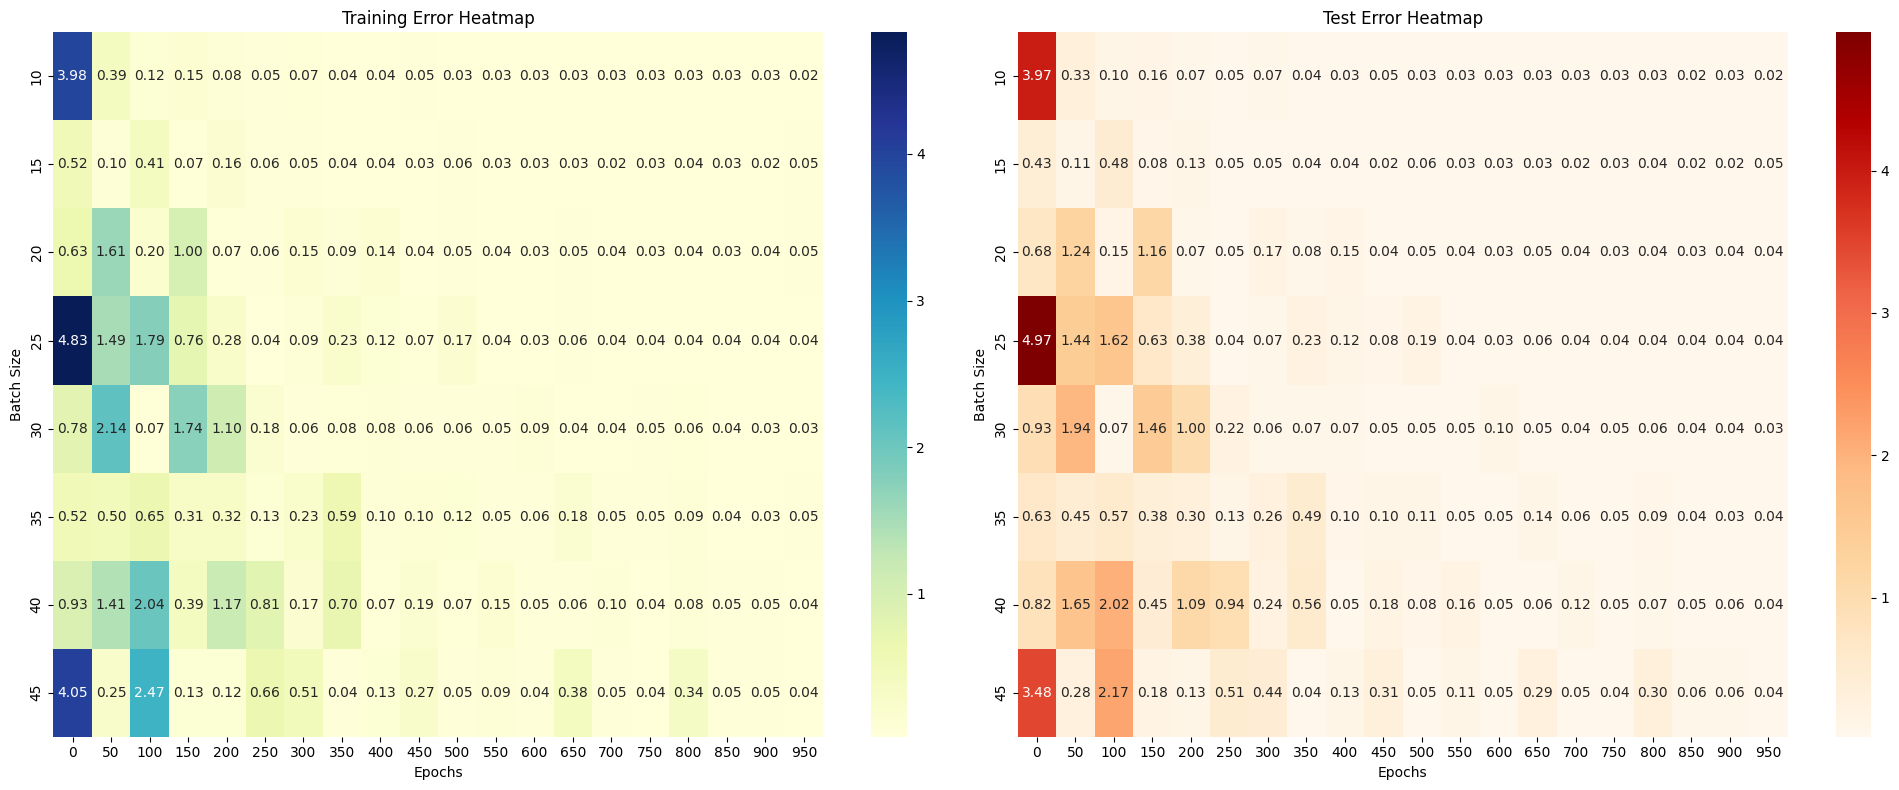

In [20]:
# Mini-batch and epoch

np.random.seed(2024)

gamma = 0.01
delta = optimal_delta
eta = 0.9
batch_size = np.arange(10, 50, 5)
max_epochs = np.arange(0, 1000, 50)

train_errors = np.zeros((len(batch_size), len(max_epochs)))
test_errors = np.zeros((len(batch_size), len(max_epochs)))

for epoch in range(len(max_epochs)):
    for b in range(len(batch_size)):
        model = GradientDescend(optimizer="sgd", method="sgd", Ridge=True, learning_rate=gamma, delta_momentum=delta, learning_rate_decay_flag=True, learning_rate_decay=eta, batch_size=batch_size[b], max_epochs=epoch)
        model.fit(X_train, z_train, X_test, z_test)
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        train_errors[b, epoch] = MSE(train_pred, z_train)
        test_errors[b, epoch] = MSE(test_pred, z_test)

# ---------------------- Plot the results ----------------------
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Training Error Heatmap
sns.heatmap(train_errors, ax=ax[0], annot=True, fmt=".2f", cmap="YlGnBu", 
            xticklabels=max_epochs, yticklabels=batch_size)
ax[0].set_title("Training Error Heatmap")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Batch Size")

# Test Error Heatmap
sns.heatmap(test_errors, ax=ax[1], annot=True, fmt=".2f", cmap="OrRd", 
            xticklabels=max_epochs, yticklabels=batch_size)
ax[1].set_title("Test Error Heatmap")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Batch Size")

plt.tight_layout()
plt.show()

Text(0, 0.5, 'train MSE')

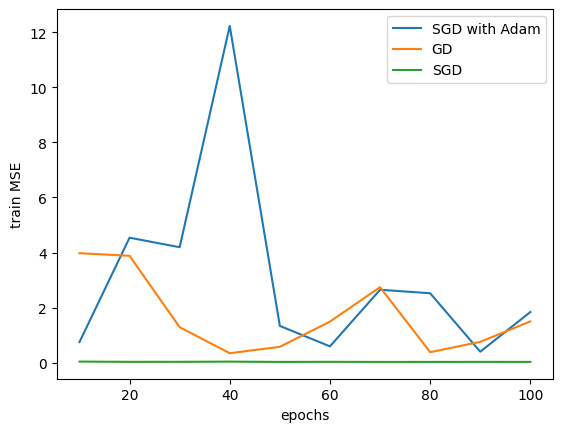

In [24]:
# Convergence and stability

np.random.seed(2024)

gamma = optimal_gamma
delta = 0.6
eta = 0.9
batch_size = 25
epochs = np.arange(10, 101, 10)

gd = np.zeros(len(epochs))
sgd = np.zeros(len(epochs))
sgd_adam = np.zeros(len(epochs))

for i in range(len(epochs)):
    model = GradientDescend(optimizer="gd", method="gd", Ridge=True, learning_rate=gamma, delta_momentum=delta, max_epochs=epochs[i])
    scores = model.fit(X_train, z_train, X_test, z_test)
    pred_train = model.predict(X_train)
    gd[i] = MSE(pred_train, z_train)

    model = GradientDescend(optimizer="sgd", method="sgd", Ridge=True, learning_rate=gamma, delta_momentum=delta,
                            learning_rate_decay_flag=True, learning_rate_decay=eta, batch_size=batch_size, max_epochs=epochs[i])
    scores = model.fit(X_train, z_train, X_test, z_test)
    pred_train = model.predict(X_train)
    sgd[i] = MSE(pred_train, z_train)

    model = GradientDescend(optimizer="sgd", method="ADAM", Ridge=True, batch_size=batch_size)
    scores = model.fit(X_train, z_train, X_test, z_test)
    pred_train = model.predict(X_train)
    sgd_adam[i] = MSE(pred_train, z_train)
    
# ---------------------- Plot the results ----------------------
# OLS = np.zeros(len(epochs))+ MSE_val[0,0]
plt.plot(epochs, sgd_adam, label="SGD with Adam")
plt.plot(epochs, gd, label="GD")
plt.plot(epochs, sgd, label="SGD")
# plt.plot(epochs, OLS, label="OLS")
plt.legend()
plt.xlabel("epochs")
plt.ylabel("train MSE")

### Adagrad, RMSprop and Adam

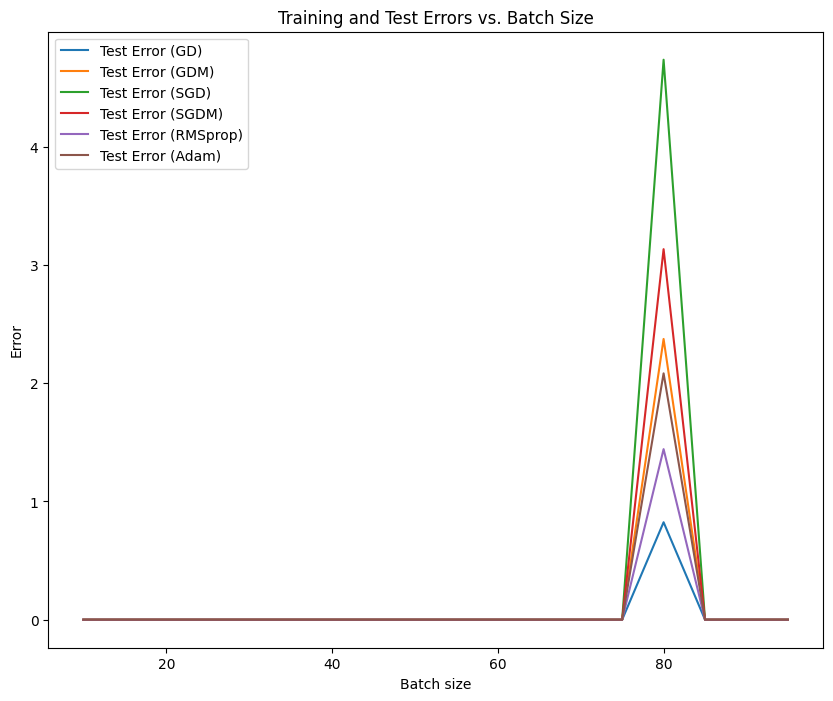

In [22]:
# Variable Batch_size
np.random.seed(2024)

gamma = 0.01
delta = optimal_delta
eta = 0.9
batch_size = np.arange(10, 100, 5)

test_errors_gd = np.zeros(len(batch_size))
test_errors_gdm = np.zeros(len(batch_size))
test_errors_sgd = np.zeros(len(batch_size))
test_errors_sgdm = np.zeros(len(batch_size))
test_errors_rms = np.zeros(len(batch_size))
test_errors_adam = np.zeros(len(batch_size))

for b in range(len(batch_size)):
    # ---------------------- GD without momentum ----------------------
    model = GradientDescend(momentum=False, method="Adagrad_GD", batch_size=batch_size[b], Ridge=True)
    model.fit(X_train, z_train, X_test, z_test)
    test_pred = model.predict(X_test)
    test_errors_gd[g] = MSE(test_pred, z_test)
    
    # ---------------------- GD with momentum ----------------------
    model = GradientDescend(method="Adagrad_GD", batch_size=batch_size[b], Ridge=True)
    model.fit(X_train, z_train, X_test, z_test)
    test_pred = model.predict(X_test)
    test_errors_gdm[g] = MSE(test_pred, z_test)
    
    # ---------------------- SGD without momentum ----------------------
    model = GradientDescend(momentum=False, optimizer='sgd', method="Adagrad_GD", batch_size=batch_size[b], Ridge=True)
    model.fit(X_train, z_train, X_test, z_test)
    test_pred = model.predict(X_test)
    test_errors_sgd[g] = MSE(test_pred, z_test)
    
    # ---------------------- SGD with momentum ----------------------
    model = GradientDescend(optimizer='sgd', method="Adagrad_GD", batch_size=batch_size[b], Ridge=True)
    model.fit(X_train, z_train, X_test, z_test)
    test_pred = model.predict(X_test)
    test_errors_sgdm[g] = MSE(test_pred, z_test)
    
    # ---------------------- RMS with momentum ----------------------
    model = GradientDescend(optimizer='sgd', method="RMSprop", batch_size=batch_size[b], Ridge=True)
    model.fit(X_train, z_train, X_test, z_test)
    test_pred = model.predict(X_test)
    test_errors_rms[g] = MSE(test_pred, z_test)
    
    # ---------------------- ADAM with momentum ----------------------
    model = GradientDescend(optimizer='sgd', method="ADAM", batch_size=batch_size[b], Ridge=True)
    model.fit(X_train, z_train, X_test, z_test)
    test_pred = model.predict(X_test)
    test_errors_adam[g] = MSE(test_pred, z_test)

# ---------------------- Plot the results ----------------------
plt.figure(figsize=(10, 8))
plt.plot(batch_size, test_errors_gd, label="Test Error (GD)")
plt.plot(batch_size, test_errors_gdm, label="Test Error (GDM)")
plt.plot(batch_size, test_errors_sgd, label="Test Error (SGD)")
plt.plot(batch_size, test_errors_sgdm, label="Test Error (SGDM)")
plt.plot(batch_size, test_errors_rms, label="Test Error (RMSprop)")
plt.plot(batch_size, test_errors_adam, label="Test Error (Adam)")

plt.title("Training and Test Errors vs. Batch Size")
plt.xlabel("Batch size")
plt.ylabel("Error")
plt.legend()
plt.show()

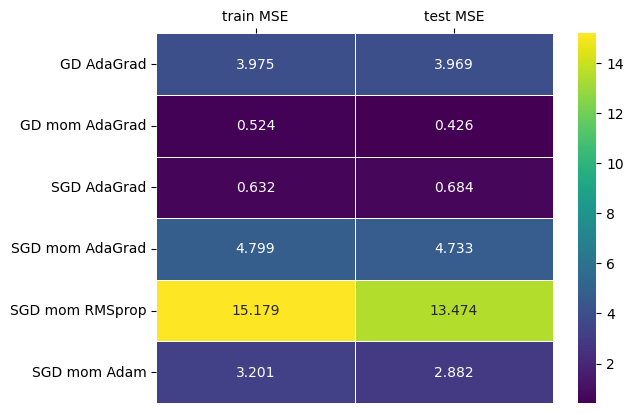

In [23]:
np.random.seed(2024)

gamma = 0.01
delta = optimal_delta
eta = 0.9
batch_size = 25

MSE_val = np.zeros((6, 2))

# ---------------------- GD without momentum ----------------------
model = GradientDescend(momentum=False, method="Adagrad_GD", batch_size=batch_size, Ridge=True)
model.fit(X_train, z_train, X_test, z_test)
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
MSE_val[0, 0] = MSE(train_pred, z_train)
MSE_val[0, 1] = MSE(test_pred, z_test)

# ---------------------- GD with momentum ----------------------
model = GradientDescend(method="Adagrad_GD", batch_size=batch_size, Ridge=True)
model.fit(X_train, z_train, X_test, z_test)
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
MSE_val[1, 0] = MSE(train_pred, z_train)
MSE_val[1, 1] = MSE(test_pred, z_test)

# ---------------------- SGD without momentum ----------------------
model = GradientDescend(momentum=False, optimizer='sgd', method="Adagrad_GD", batch_size=batch_size, Ridge=True)
model.fit(X_train, z_train, X_test, z_test)
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
MSE_val[2, 0] = MSE(train_pred, z_train)
MSE_val[2, 1] = MSE(test_pred, z_test)

# ---------------------- SGD with momentum ----------------------
model = GradientDescend(optimizer='sgd', method="Adagrad_GD", batch_size=batch_size, Ridge=True)
model.fit(X_train, z_train, X_test, z_test)
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
MSE_val[3, 0] = MSE(train_pred, z_train)
MSE_val[3, 1] = MSE(test_pred, z_test)

# ---------------------- RMS with momentum ----------------------
model = GradientDescend(optimizer='sgd', method="RMSprop", batch_size=batch_size, Ridge=True)
model.fit(X_train, z_train, X_test, z_test)
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
MSE_val[4, 0] = MSE(train_pred, z_train)
MSE_val[4, 1] = MSE(test_pred, z_test)

# ---------------------- ADAM with momentum ----------------------
model = GradientDescend(optimizer='sgd', method="ADAM", batch_size=batch_size, Ridge=True)
model.fit(X_train, z_train, X_test, z_test)
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)
MSE_val[5, 0] = MSE(train_pred, z_train)
MSE_val[5, 1] = MSE(test_pred, z_test)

# ---------------------- Plot the results ----------------------
index = ["GD AdaGrad", "GD mom AdaGrad", "SGD AdaGrad", "SGD mom AdaGrad", "SGD mom RMSprop", "SGD mom Adam"]
MSE_val = np.around(MSE_val, decimals=3)
df = pd.DataFrame(MSE_val, index=index, columns=["train MSE", "test MSE"])
fig = sns.heatmap(df, cmap="viridis", annot=True, linewidth=.5, fmt=".3f")
fig.set(xlabel="", ylabel="")
fig.xaxis.tick_top()